
# ECG Binary Classification (PyTorch) — From Normalization to Evaluation

This notebook trains a **binary CNN** on an ECG image dataset structured as:

```
processed_dataset/
  Anormal/
  Normal/
```

It covers:
1. Mean/Std computation (for normalization).
2. Dataset split (80/10/10) with stratification.
3. PyTorch DataLoaders (GPU-ready).
4. Simple CNN (binary head with BCEWithLogitsLoss).
5. Training loop with AMP (mixed precision), tracking **loss** and **accuracy**.
6. Plots for loss & accuracy.
7. Final evaluation (Accuracy, Precision, Recall, F1, AUC, Confusion Matrix, Classification Report).


In [9]:

# ===== 0) Setup & Config =====
import os, numpy as np, torch, matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import random

SEED     = 42
IMG_SIZE = 224
BATCH    = 64
ROOT     = "processed_dataset"   
# Reproducibility & GPU
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
torch.backends.cudnn.benchmark = True  # speed up CNN on fixed input sizes
torch.backends.cudnn.deterministic = False  # faster but less reproducible


Device: cuda


## 1) Compute mean & std (grayscale, in [0,1])

In [10]:

# Vérifier que le dossier existe
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"Le dossier '{ROOT}' n'existe pas. Vérifiez le chemin.")

# Temporary transform to compute mean/std (no Normalize yet)
tx_tmp = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),           # -> [0,1]
])

ds_tmp = datasets.ImageFolder(ROOT, transform=tx_tmp)
print(f"Dataset trouvé: {len(ds_tmp)} images dans {len(ds_tmp.classes)} classes")
loader_tmp = DataLoader(ds_tmp, batch_size=128, num_workers=min(8, os.cpu_count() or 1), shuffle=False)

psum = 0.0
psum_sq = 0.0
count = 0

for x, _ in loader_tmp:
    b = x.size(0)        # [B,1,H,W]
    x = x.view(b, -1)
    psum    += x.sum()
    psum_sq += (x**2).sum()
    count   += x.numel()

mean = (psum / count).item()
std  = ((psum_sq / count - mean**2) ** 0.5).item()
print(f"mean={mean:.6f}, std={std:.6f}")


Dataset trouvé: 568 images dans 2 classes
mean=0.450339, std=0.175678


## 2) Dataset with Normalize & Train/Val/Test split (80/10/10, stratified)

In [11]:

MEAN, STD = mean, std

tx = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                 # -> [0,1]
    transforms.Normalize([MEAN], [STD]),   # normalization
])

ds = datasets.ImageFolder(ROOT, transform=tx)
print(f"Dataset chargé: {len(ds)} images")
y  = np.array(ds.targets)
idx = np.arange(len(ds))

# 80/20 -> then 10/10 from the 20
idx_tr, idx_tmp, y_tr, y_tmp = train_test_split(
    idx, y, test_size=0.20, random_state=SEED, stratify=y
)
idx_va, idx_te, y_va, y_te = train_test_split(
    idx_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp
)

train_set, val_set, test_set = Subset(ds, idx_tr), Subset(ds, idx_va), Subset(ds, idx_te)

num_workers = min(8, os.cpu_count() or 1)
pin = (device.type == "cuda")
# persistent_workers nécessite num_workers > 0 et peut causer des problèmes sur certains systèmes
use_persistent_workers = (num_workers > 0) and (device.type == "cuda")

train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,
                          num_workers=num_workers, pin_memory=pin, 
                          persistent_workers=use_persistent_workers)
val_loader   = DataLoader(val_set,   batch_size=BATCH, shuffle=False,
                          num_workers=num_workers, pin_memory=pin, 
                          persistent_workers=use_persistent_workers)
test_loader  = DataLoader(test_set,  batch_size=BATCH, shuffle=False,
                          num_workers=num_workers, pin_memory=pin, 
                          persistent_workers=use_persistent_workers)

print("Classes:", ds.classes, ds.class_to_idx)  # e.g. ['Anormal','Normal'] -> {'Anormal':0,'Normal':1}


Dataset chargé: 568 images
Classes: ['Anormal', 'Normal'] {'Anormal': 0, 'Normal': 1}


## 3) Model (binary head with BCEWithLogitsLoss)

In [12]:

import torch.nn as nn

class SimpleECGCNN(nn.Module):
    def __init__(self, img_size=IMG_SIZE):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 112x112
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 28x28
            nn.Flatten(),
            nn.Linear(64 * (img_size//8) * (img_size//8), 1)              # single logit
        )
    def forward(self, x):
        return self.net(x)

model = SimpleECGCNN().to(device)
criterion = nn.BCEWithLogitsLoss()                 # stable (Sigmoid + BCE in one)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# optional: learning-rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


C:\Users\ilias\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 4) Training with AMP (loss & accuracy tracked)

In [13]:

# Utiliser l'ancienne API torch.cuda.amp (compatible avec toutes les versions)
from torch.cuda.amp import autocast, GradScaler

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
scaler = GradScaler(enabled=(device.type == "cuda"))

def epoch_pass(model, loader, device, optimizer=None, criterion=None, threshold=0.5):
    train_mode = optimizer is not None
    if train_mode:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    n_samples  = 0
    n_correct  = 0

    use_amp = (device.type == "cuda")

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.float().unsqueeze(1).to(device, non_blocking=True)  # [B,1]
        bs = xb.size(0)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            # L'ancienne API autocast() ne prend pas de paramètres, fonctionne uniquement avec CUDA
            if use_amp:
                with autocast():
                    logits = model(xb)                 # [B,1]
                    loss   = criterion(logits, yb)     # BCEWithLogitsLoss
            else:
                # Pas d'AMP sur CPU
                logits = model(xb)                 # [B,1]
                loss   = criterion(logits, yb)     # BCEWithLogitsLoss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Mode évaluation
            if use_amp:
                with torch.no_grad(), autocast():
                    logits = model(xb)
                    loss   = criterion(logits, yb)
            else:
                # Pas d'AMP sur CPU
                with torch.no_grad():
                    logits = model(xb)
                    loss   = criterion(logits, yb)

        # Accuracy
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
        y_int = yb.long()

        n_correct  += (preds == y_int).sum().item()
        n_samples  += bs
        total_loss += loss.item() * bs

    mean_loss = total_loss / max(1, n_samples)
    acc = n_correct / max(1, n_samples)
    return mean_loss, acc

EPOCHS = 50
best_val = float('inf')
best_state = None

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = epoch_pass(model, train_loader, device, optimizer=optimizer, criterion=criterion)
    va_loss, va_acc = epoch_pass(model, val_loader,   device, optimizer=None,  criterion=criterion)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    scheduler.step(va_loss)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} train_acc={tr_acc*100:.2f}% "
          f"val_loss={va_loss:.4f}   val_acc={va_acc*100:.2f}%" )

    if va_loss < best_val:
        best_val = va_loss
        best_state = {"epoch": epoch,
                      "model": model.state_dict(),
                      "optimizer": optimizer.state_dict()}

# Save best model checkpoint
if best_state is not None:
    os.makedirs("checkpoints", exist_ok=True)
    torch.save(best_state, "checkpoints/best_cnn_binary.pt")
    print(f"\nBest epoch: {best_state['epoch']} | val_loss: {best_val:.4f}")
    print("Checkpoint sauvegardé: checkpoints/best_cnn_binary.pt")
else:
    print("\nAttention: Aucun modèle n'a été sauvegardé (best_state est None)")


C:\Users\ilias\AppData\Local\Temp\ipykernel_11504\4228589559.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))
C:\Users\ilias\AppData\Local\Temp\ipykernel_11504\4228589559.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ilias\AppData\Local\Temp\ipykernel_11504\4228589559.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


[01/50] train_loss=1.1159 train_acc=50.00% val_loss=0.6929   val_acc=49.12%
[02/50] train_loss=0.6927 train_acc=50.44% val_loss=0.6927   val_acc=49.12%
[03/50] train_loss=0.6883 train_acc=50.44% val_loss=0.6799   val_acc=68.42%
[04/50] train_loss=0.6886 train_acc=57.93% val_loss=0.6797   val_acc=50.88%
[05/50] train_loss=0.6788 train_acc=59.91% val_loss=0.6689   val_acc=64.91%
[06/50] train_loss=0.6650 train_acc=61.01% val_loss=0.6492   val_acc=64.91%
[07/50] train_loss=0.6407 train_acc=61.23% val_loss=0.6240   val_acc=64.91%
[08/50] train_loss=0.5911 train_acc=74.45% val_loss=0.6493   val_acc=49.12%
[09/50] train_loss=0.5422 train_acc=73.13% val_loss=0.5139   val_acc=78.95%
[10/50] train_loss=0.4735 train_acc=80.40% val_loss=0.4498   val_acc=84.21%
[11/50] train_loss=0.4076 train_acc=85.24% val_loss=0.4768   val_acc=75.44%
[12/50] train_loss=0.3653 train_acc=85.68% val_loss=0.3218   val_acc=87.72%
[13/50] train_loss=0.3219 train_acc=87.44% val_loss=0.3350   val_acc=87.72%
[14/50] trai

## 5) Plot training/validation curves (Loss & Accuracy)

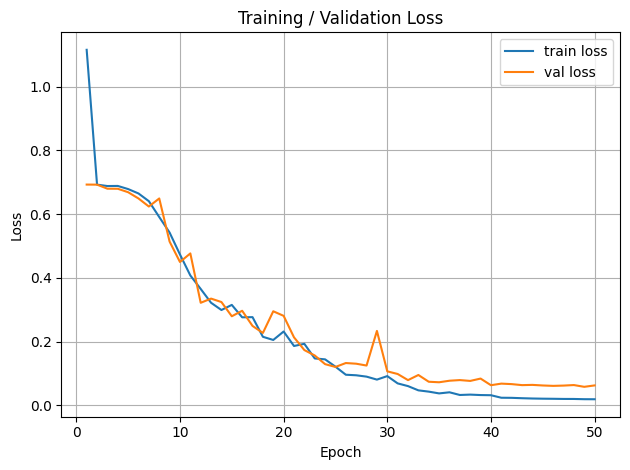

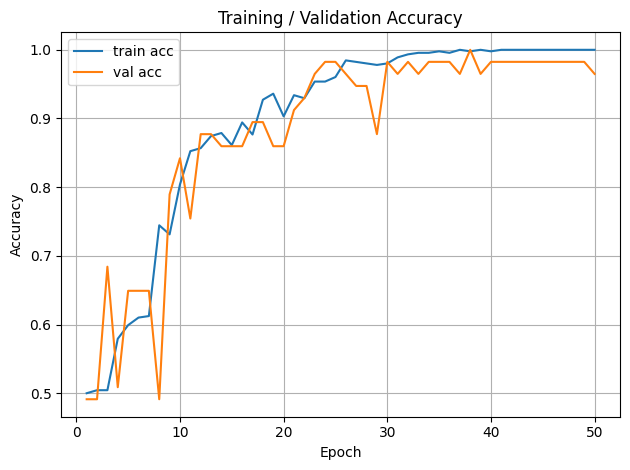

Saved figures: loss_curve.png, acc_curve.png


In [14]:

# Utiliser numpy déjà importé
epochs = np.arange(1, len(history["train_loss"]) + 1)

# Loss
plt.figure()
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"],   label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training / Validation Loss"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=150)
plt.show()

# Accuracy
plt.figure()
plt.plot(epochs, history["train_acc"], label="train acc")
plt.plot(epochs, history["val_acc"],   label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training / Validation Accuracy"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig("acc_curve.png", dpi=150)
plt.show()

print("Saved figures: loss_curve.png, acc_curve.png")


## 6) Evaluation block (Accuracy, Precision, Recall, F1, AUC, Confusion Matrix)

In [ ]:

# torch et numpy sont déjà importés dans la cellule 1
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix, classification_report
)

@torch.no_grad()
def evaluate_binary(model, loader, device, threshold=0.5, positive_label=1):
    model.eval()
    all_probs, all_targets = [], []
    use_amp = (device.type == "cuda")
    
    # Utiliser l'ancienne API torch.cuda.amp (compatible avec toutes les versions)
    from torch.cuda.amp import autocast

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        
        # Utiliser autocast uniquement sur CUDA (ancienne API)
        if use_amp:
            with autocast():
                logits = model(xb)            # [B,1]
        else:
            # Pas d'AMP sur CPU
            logits = model(xb)            # [B,1]
        
        # Utiliser squeeze(-1) ou reshape pour être sûr de la forme
        if logits.dim() == 2 and logits.size(1) == 1:
            probs = torch.sigmoid(logits).squeeze(-1).float().cpu().numpy()
        else:
            probs = torch.sigmoid(logits).float().cpu().numpy()
        all_probs.append(probs)
        all_targets.append(yb.long().cpu().numpy())

    y_true = np.concatenate(all_targets, axis=0)
    y_prob = np.concatenate(all_probs, axis=0)
    y_pred = (y_prob >= threshold).astype(np.int64)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=positive_label
    )
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    report = classification_report(y_true, y_pred, digits=4)
    return {"accuracy": acc, "precision": prec, "recall": rec,
            "f1": f1, "auc": auc, "confusion_matrix": cm, "report": report}


### Run final evaluation on **test** set

In [16]:

# Load best weights (vérifier si le fichier existe)
checkpoint_path = "checkpoints/best_cnn_binary.pt"
if os.path.exists(checkpoint_path):
    best_ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(best_ckpt["model"])
    print(f"Modèle chargé depuis l'epoch {best_ckpt.get('epoch', 'N/A')}")
else:
    print("Attention: Le checkpoint n'existe pas. Utilisation du modèle actuel.")
    print("Assurez-vous d'avoir exécuté la cellule de training d'abord.")

metrics = evaluate_binary(model, test_loader, device, threshold=0.5, positive_label=1)
print("\n=== Test metrics ===")
print(f"Accuracy : {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall   : {metrics['recall']:.4f}")
print(f"F1       : {metrics['f1']:.4f}")
print(f"AUC      : {metrics['auc']:.4f}")
print("Confusion matrix:\n", metrics["confusion_matrix"])
print(metrics["report"])


Modèle chargé depuis l'epoch 49


C:\Users\ilias\AppData\Local\Temp\ipykernel_11504\650395006.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_ckpt = torch.load(checkpoint_path, map_location=device)



=== Test metrics ===
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
AUC      : 1.0000
Confusion matrix:
 [[29  0]
 [ 0 28]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        29
           1     1.0000    1.0000    1.0000        28

    accuracy                         1.0000        57
   macro avg     1.0000    1.0000    1.0000        57
weighted avg     1.0000    1.0000    1.0000        57



C:\Users\ilias\AppData\Local\Temp\ipykernel_11504\2741517192.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
